# WRANGLE.PY

### Throughout the exercises for Regression in Python lessons, you will use the following example scenario: As a customer analyst, I want to know who has spent the most money with us over their lifetime. I have monthly charges and tenure, so I think I will be able to use those two attributes as features to estimate total_charges. I need to do this within an average of $5.00 per customer.
- The first step will be to acquire and prep the data. Do your work for this exercise in a file named wrangle.py.

### Imports

In [33]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 
import os
from env import host, user, password 
import wrangle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


#### 1. Acquire customer_id, monthly_charges, tenure, and total_charges from telco_churn database for all customers with a 2 year contract.

##### Aquire the Data

In [3]:
#connection to codeup database
def get_connection(db, user=user, host=host, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [4]:
#sql query used to get 2 year contract data
sql_query = '''
            SELECT customer_id, monthly_charges, tenure, total_charges, contract_type_id
            FROM customers
            JOIN contract_types USING(`contract_type_id`)
            WHERE contract_type_id = '3';
            '''

In [56]:
#function to acquire dataframe
def acquire_telco():
     if os.path.isfile('telco_churn.csv') == False:
         sql_query = '''
                        SELECT customer_id, monthly_charges, tenure, total_charges, contract_type_id
                        FROM customers
                        JOIN contract_types USING(`contract_type_id`)
                        WHERE contract_type_id = '3';
                    '''
         df = pd.read_sql(sql_query, get_connection('telco_churn'))
         df.to_csv('telco_churn.csv')
     else:
        df = pd.read_csv('telco_churn.csv', index_col=0)
     return df


In [6]:
df = get_telco_data()

In [7]:
df.head()

,customer_id,monthly_charges,tenure,total_charges,contract_type_id
0,0013-SMEOE,109.70,71,7904.25,3
1,0014-BMAQU,84.65,63,5377.8,3
2,0016-QLJIS,90.45,65,5957.9,3
3,0017-DINOC,45.20,54,2460.55,3
4,0017-IUDMW,116.80,72,8456.75,3


#### 2. Walk through the steps above using your new dataframe. You may handle the missing values however you feel is appropriate.

##### Sample and Summarize

In [8]:
#shape
df.shape

(1695, 5)

In [9]:
# info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1695 entries, 0 to 1694
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       1695 non-null   object 
 1   monthly_charges   1695 non-null   float64
 2   tenure            1695 non-null   int64  
 3   total_charges     1695 non-null   object 
 4   contract_type_id  1695 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 66.3+ KB


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>- Total charges is an object type, when it should probably be int or float, so there might be nulls in here.</div>

In [10]:
#distribution of numerical variables
df.describe()

,monthly_charges,tenure,contract_type_id
count,1695.000000,1695.000000,1695.0
mean,60.770413,56.735103,3.0
std,34.678865,18.209363,0.0
min,18.400000,0.000000,3.0
25%,24.025000,48.000000,3.0
50%,64.350000,64.000000,3.0
75%,90.450000,71.000000,3.0
max,118.750000,72.000000,3.0


In [11]:
#lets look at total charges to see what might be causing the variable to 
#be labeled as an object
df.total_charges.value_counts()

           10
1161.75     2
7334.05     2
5714.2      2
343.45      2
           ..
1250.1      1
5443.65     1
6316.2      1
2431.95     1
6352.4      1
Name: total_charges, Length: 1678, dtype: int64

In [17]:
#hard to see with so many values
#let's check for nulls
df.isna().sum()

customer_id         0
monthly_charges     0
tenure              0
total_charges       0
contract_type_id    0
dtype: int64

<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>- No nulls observed in current dataset, the nulls that were present in total charges were from MTM and 1 year contracts</div>

In [21]:
#Let's change total charges to numeric
df['total_charges'] = pd.to_numeric(df.total_charges, errors='coerce')

In [22]:
#Check to see that it is now numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1695 entries, 0 to 1694
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       1695 non-null   object 
 1   monthly_charges   1695 non-null   float64
 2   tenure            1695 non-null   int64  
 3   total_charges     1685 non-null   float64
 4   contract_type_id  1695 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 66.3+ KB


In [ ]:
#drop the columns we will not be utilizing


In [24]:
df = df.drop(columns=['customer_id', 'contract_type_id'])

In [25]:
df.head()

,monthly_charges,tenure,total_charges
0,109.70,71,7904.25
1,84.65,63,5377.80
2,90.45,65,5957.90
3,45.20,54,2460.55
4,116.80,72,8456.75


##### Visualize Distribution

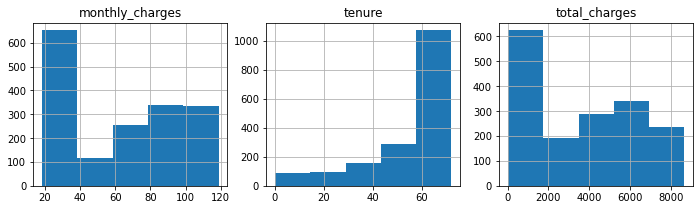

In [26]:
plt.figure(figsize=(16, 3))

for i, col in enumerate(['monthly_charges', 'tenure', 'total_charges']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]  
    plt.subplot(1,4, plot_number)
    plt.title(col)
    series.hist(bins=5)

<AxesSubplot:>

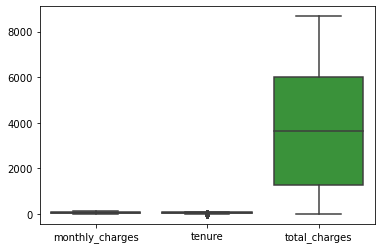

In [32]:
#boxplot
sns.boxplot(data=df)

##### Train, Test, Split

In [34]:
train_val, test = train_test_split(df, train_size=0.8, random_state=123)


In [35]:
train, validate = train_test_split(train_val, train_size=0.7, random_state=123)


In [36]:
#observe size of train
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 949 entries, 1256 to 1593
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   monthly_charges  949 non-null    float64
 1   tenure           949 non-null    int64  
 2   total_charges    942 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 29.7 KB


#### 3. End with a python file wrangle.py that contains the function, wrangle_telco(), that will acquire the data and return a dataframe cleaned with no missing values.

##### Pipeline Function

In [57]:
#all reproducable functions used
def get_connection(db, user=user, host=host, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
#function to acquire dataframe
def acquire_telco():
     if os.path.isfile('telco_churn.csv') == False:
         sql_query = '''
                        SELECT customer_id, monthly_charges, tenure, total_charges, contract_type_id
                        FROM customers
                        JOIN contract_types USING(`contract_type_id`)
                        WHERE contract_type_id = '3';
                    '''
         df = pd.read_sql(sql_query, get_connection('telco_churn'))
         df.to_csv('telco_churn.csv')
     else:
        df = pd.read_csv('telco_churn.csv', index_col=0)
     return df

def clean_telco(df):
    '''
    Takes in a df of telco customer monthly charges, tenure, total charges
    and cleans the data appropriately by ,
    and converting object data to numerical data
    as well as dropping cutomer_id and contract_type_id columns from the dataframe
    return: df, a cleaned pandas dataframe
    '''
    df['total_charges'] = pd.to_numeric(df.total_charges, errors='coerce')
    df = df.drop(columns=['customer_id', 'contract_type_id'])
    return df


def split_data(df):
    '''
    split our data,
    takes in a pandas dataframe
    returns: three pandas dataframes, train, test, and validate
    '''
    train_val, test = train_test_split(df, train_size=0.8, random_state=1349, stratify=df.total_charges)
    train, validate = train_test_split(train_val, train_size=0.7, random_state=1349, stratify=train_val.total_charges)
    return train, validate, test



In [58]:
def wrangle_telco():
    '''
    wrangle_telco will read in our telco dataset as a pandas df,
    clean the data,
    split the data,
    return: train, validate, test sets of pandas dataframes from telco data
    stratified on total_charges
    
    '''
    df = clean_telco(acquire_telco())
    return split_data(df)

In [59]:
df2 = clean_telco(acquire_telco())

In [60]:
df2.head()

,monthly_charges,tenure,total_charges
0,109.70,71,7904.25
1,84.65,63,5377.80
2,90.45,65,5957.90
3,45.20,54,2460.55
4,116.80,72,8456.75
